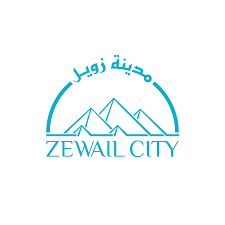

<h1 align="center">Zewail University of Science and Technology
</h1>

<h1 align="center">Biomedical Sciences_ Computational Biology and Genomics_BMS 474</h1>
<h1 align="center">FALL 2023	</h1>
<h1 align="center">Assignment 3 </h1>


#Initial Code Setup: Decision Tree

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import random
from pprint import pprint

## Helper Functions

In [ ]:
# 1. Train-Test-Split
def train_test_split(df, test_size, seed=None): # I edited this function

    if isinstance(test_size, float):
        test_size = round(test_size * len(df))

    if seed is not None:
      random.seed(seed)

    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)

    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)

    return train_df, test_df


# 2. Distinguish categorical and continuous features
def determine_type_of_feature(df):

    feature_types = []
    n_unique_values_treshold = 15
    for feature in df.columns:
        if feature != "label":
            unique_values = df[feature].unique()
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")

    return feature_types


# 3. Accuracy
def calculate_accuracy(predictions, labels):
    predictions_correct = predictions == labels
    accuracy = predictions_correct.mean()

    return accuracy

##Desision Tree

In [ ]:
# 1.1 Data pure?
def check_purity(data):

    label_column = data[:, -1]
    unique_classes = np.unique(label_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False


# 1.2 Classify
def classify_data(data):

    label_column = data[:, -1]
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)

    index = counts_unique_classes.argmax()
    classification = unique_classes[index]

    return classification


# 1.3 Potential splits?
def get_potential_splits(data, random_subspace):

    potential_splits = {}
    _, n_columns = data.shape
    column_indices = list(range(n_columns - 1))    # excluding the last column which is the label

    if random_subspace and random_subspace <= len(column_indices):
        column_indices = random.sample(population=column_indices, k=random_subspace)

    for column_index in column_indices:
        values = data[:, column_index]
        unique_values = np.unique(values)

        potential_splits[column_index] = unique_values

    return potential_splits


# 1.4 Lowest Overall Entropy?
def calculate_entropy(data):

    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))

    return entropy


def calculate_overall_entropy(data_below, data_above):

    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_entropy =  (p_data_below * calculate_entropy(data_below)
                      + p_data_above * calculate_entropy(data_above))

    return overall_entropy


def determine_best_split(data, potential_splits):

    overall_entropy = 9999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            current_overall_entropy = calculate_overall_entropy(data_below, data_above)

            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value

    return best_split_column, best_split_value


# 1.5 Split data
def split_data(data, split_column, split_value):

    split_column_values = data[:, split_column]

    type_of_feature = FEATURE_TYPES[split_column]
    if type_of_feature == "continuous":
        data_below = data[split_column_values <= split_value]
        data_above = data[split_column_values >  split_value]

    # feature is categorical
    else:
        data_below = data[split_column_values == split_value]
        data_above = data[split_column_values != split_value]

    return data_below, data_above


# 2. Decision Tree Algorithm
def decision_tree_algorithm(df, counter=0, min_samples=2, max_depth=5, random_subspace=None):

    # data preparations
    if counter == 0:
        global COLUMN_HEADERS, FEATURE_TYPES
        COLUMN_HEADERS = df.columns
        FEATURE_TYPES = determine_type_of_feature(df)
        data = df.values
    else:
        data = df


    # base cases
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)

        return classification


    # recursive part
    else:
        counter += 1

        # helper functions
        potential_splits = get_potential_splits(data, random_subspace)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)

        # check for empty data
        if len(data_below) == 0 or len(data_above) == 0:
            classification = classify_data(data)
            return classification

        # determine question
        feature_name = COLUMN_HEADERS[split_column]
        type_of_feature = FEATURE_TYPES[split_column]
        if type_of_feature == "continuous":
            question = "{} <= {}".format(feature_name, split_value)

        # feature is categorical
        else:
            question = "{} = {}".format(feature_name, split_value)

        # instantiate sub-tree
        sub_tree = {question: []}

        # find answers (recursion)
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples, max_depth, random_subspace)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples, max_depth, random_subspace)

        # If the answers are the same, then there is no point in asking the qestion.
        # This could happen when the data is classified even though it is not pure
        # yet (min_samples or max_depth base case).
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)

        return sub_tree


# 3. Make predictions
# 3.1 One example
def predict_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.rsplit(" ", 2)

    # ask question
    if comparison_operator == "<=":
        if example[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]

    # feature is categorical
    else:
        if str(example[feature_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer

    # recursive part
    else:
        residual_tree = answer
        return predict_example(example, residual_tree)


# 3.2 All examples of the test data
def decision_tree_predictions(test_df, tree):
    predictions = test_df.apply(predict_example, args=(tree,), axis=1)
    return predictions

#Task 1: Build your own Random Forest classifier from scratch

By following the steps below, you will gain a deeper understanding of how Random Forest works and how it combines multiple Decision Trees for improved performance.

Implement the following functions for Random Forest using the above Decision Tree implementation.

## Task 1.1: Resampling(train_df, n_bootstrap)
      
- It performs Resampling on a given training dataset train_df.

- Resampling is a statistical technique that involves random sampling with replacement.

- It performs random sampling with replacement to create a new dataset containing a subset of the original rows.
      
- This technique is commonly used in ensemble learning methods like Random Forest to create diverse subsets of data for training individual models.

In [ ]:
# This is a function that takes the dataframe, the number of bootstraps, and an optional seed. It implements resampling and returns the bootstrapped dataframe
def resampling(train_df, n_bootstrap, seed=None):
  if seed is not None:
    random.seed(seed)
  resampling_indices = np.random.randint(low=0, high=len(train_df), size=n_bootstrap) # generate n_boostrap number of indices
  bootstrap_df = train_df.iloc[resampling_indices] # use the indices to subset from the original dataframe

  return bootstrap_df

## Task 1.2: random_forest_Combined(train_df, n_trees, n_bootstrap, n_features, dt_max_depth)

  - It implements the **random forest algorithm** from scratch.
  
  - It builds a random forest by repeatedly performing bootstrapping and constructing decision trees.
      
  - Each decision tree is built using a bootstrapped sample and a subset of randomly selected features.
      
  - The resulting random forest is a collection of decision trees that can be used for prediction or classification tasks.

In [ ]:
# This is a function that takes as inputs the parameters of the decision tree as well as the resampling function to do a RandomForest
# This function should build n_trees number of trees, where each tree is of a certain bootstrap
# All the trees should be appened to a "RandomForest" array
def random_forest_combined(train_df, n_trees, n_bootstrap, n_features, dt_max_depth, seed):
  RandomForest = []
  for i in range(n_trees):
    # Bootstrap the data
        bootstrap_df = resampling(train_df, n_bootstrap, seed) # using the function I built above
        # Build a decision tree on the bootstrapped data
        decision_tree = decision_tree_algorithm(bootstrap_df, max_depth = dt_max_depth, random_subspace = n_features) # if we do not specify values for the last 4 parameters, it is okay because they have default values...
        RandomForest.append(decision_tree)

  return RandomForest # the output is a list of n_trees decision trees, each with a certain bootstrapping (subset of the original data)


## Task 1.3: random_forest_predictions(test_df, forest)
  - It is used to make predictions using a trained random forest on a given test dataset test_df
  
  - It iterates over each decision tree in the forest, makes predictions using the corresponding tree,and stores the predictions in a DataFrame.
  
  - The final predictions for the random forest are determined by taking the mode of the predictions across all decision trees.

In [ ]:
from scipy import stats

# This is a function that takes a test dataframe as an input as well as the RandomForest model that contains n_trees number of trees
def random_forest_predictions(test_df, forest):
  predictions_df = pd.DataFrame() # creating a dataframe to save the predictions of every tree

  # then I loop over all the RandomForest trees, checking the accuracy of every decision tree
  for i in range(len(forest)):
    predictions = decision_tree_predictions(test_df.iloc[:,:-1], forest[i]) # making predictions using the already implemented function decision_tree_predictions
    predictions_df['tree_' + str(i)] = predictions
  # predictions_df is now 2D dataframe where the columns are called 'tree_0', 'tree_1', until 'tree_n_trees - 1'
  # and the rows are the samples in the test_df
  # Every sample in the test_df has n predictions across all the trees. For every sample, we want the mode.. so we want the mode across the columns

  random_forest_predictions = stats.mode(predictions_df, axis=1)[0] # The mode of all predictions using stats function
  # The [0] because stats.mode returns an object where the first element is the mode itself, and the second element is its count
  # I only want the mode, not its count, so I index the first element

  # random_forest_predictions is now expected to be a 2D array where every rows corresponds to the mode prediction score. It is expetced to be 2D because this is how stats.mode works. It takes a 2D dataframe and outputs a 2D array.
  # I only want the mode scores themselves, so I flatten it to become 1D. The flattened array should have the mode prediction scores, where every element corresponds to a certain sample

  return random_forest_predictions.flatten() # this is a 1-D array that will be suitable for the calculate_accuracy function

# Task 2:
Use your RF classifier you just built from scratch in classifying iris-data.Then, compare its accuracy to using decision tree.

## Task 2.1: Use your RF classifier you just built from scratch in classifying iris-data.

Using
seed =0,
n_trees=4,
n_bootstrap=800,
n_features=4,
dt_max_depth=4


In [ ]:
from sklearn.datasets import load_iris

n_trees = 4
n_bootstrap = 800
n_features = 4
dt_max_depth = 4

iris_df = load_iris() # Loading the iris dataframe

X, Y = iris_df.data, iris_df.target # Separating the features and the labels

iris_df = pd.DataFrame(X, columns=iris_df.feature_names) # Converting the scikit-learn array into a dataframe, where the data is the features and the column names are the feature names from the feature_names attribute of the load_iris function

iris_df['label'] = Y # Adding a column called label where its values are the values in the Y array

train_df, test_df = train_test_split(iris_df, test_size=0.2, seed=0) # Splitting the data into training and testing using the helper function from above
# I will put seed = 0 here only, but not in the bootstrapping function

forest = random_forest_combined(train_df, n_trees=n_trees, n_bootstrap=n_bootstrap, n_features=n_features, dt_max_depth=dt_max_depth) # Random Forest Classifier
# The optimal way to choose the parameters would be to do as we did in Lab 7 to find the optimal combination :'D
rf_predictions = random_forest_predictions(test_df, forest) # calling the random_forest_predictions function I just made above
# Note I pass test_df and not test_df.iloc[:,:-1] because random_forest_predictions handles this inside it..
# So if I actually pass test_df.iloc[:,:-1] this means that two columns will be removed, the label column and the one preciding it
rf_accuracy = calculate_accuracy(rf_predictions, test_df['label'].values) # Calling the helper function calculate_accuracy, which takes the predicted labels and the true labels as inputs to calculate the accuracy (mean score)

# After running the code with everything as it is, it was giving me the error below, which means that rf_predictions = random_forest_predictions(test_df, forest) was producing an error
# because it was calling the predict_example function
# After analyzing the error, it seems a problem with the splitting of the predict_example function.
# Eventually rsplit(" ", 2) helped resolving it. Why?
# I depended on this link to arrive at this solution: https://www.w3schools.com/python/ref_string_rsplit.asp#:~:text=The%20rsplit()%20method%20splits,number%20of%20elements%20plus%20one.

# 167 def predict_example(example, tree):
#     168     question = list(tree.keys())[0]
# --> 169     feature_name, comparison_operator, value = question.split(" ")
#     170
#     171     # ask question

# ValueError: too many values to unpack (expected 3)

## Task 2.2: lets compare it to using DT

In [ ]:
# Doing the same but for the decision tree classifier
tree = decision_tree_algorithm(train_df, max_depth=dt_max_depth, random_subspace = n_features) # I guess the random_subspace is equivalent to the number of features? I don't remember :'D
dt_predictions = decision_tree_predictions(test_df.iloc[:, :-1], tree)
dt_accuracy = calculate_accuracy(dt_predictions.values, test_df['label'].values)

# Comparing the accuracies
print("Random Forest Accuracy: ", rf_accuracy) # 0.9333333333333333 - for a given seed of 0 in train_test_split
print("Decision Tree Accuracy: ", dt_accuracy) # 0.9333333333333333 - for a given seed of 0 in train_test_split

# Their accuracies range from 0.8666666666666667 to 1.0, they're very similar tho. Maybe RF could be enhanced if the parameters are optimized. Also, this is an educational dataset, so it's very neat and clean.

Random Forest Accuracy:  0.9333333333333333
Decision Tree Accuracy:  0.9333333333333333


#Task 3: Use the GSE45827 dataset for primary invasive breast cancer

you are  required to do the following using Scikit package :

1- Apply normalization step using standard scalar class (2 mark)

2- Perform PCA on the features (FV length= 50). (2 mark)

3- Use the  Random Forest classifier in the classification step (No. of decision trees is 20). (2 mark)

4- Split your data into training and testing (%80 training set-%20 testing) and report your accuracy (F score). (3 marks)

5- Now, implement K fold cross validation for evaluation (K = 5) and report the accuracy (F-score). (5 marks)

6- Discuss the results you got from 4 and 5. (2 mark)

7- Try different number of trees[50,60,70,80,90,100] in the random forest algorithm and decide which one is better(2 mark)


In [ ]:
# All the neccessary imports
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
import GEOparse

# 1. First, I will load the GSE45827 dataset using GEOparse package
gse = GEOparse.get_GEO(geo="GSE45827")

# 2. Then, I will do all the neccessary pre-processing

# This dataset contains 130 tumor samples as well as 11 normal tissues samples and 14 cell lines, for a total of 155 samples

dataframes = {} # a dictionary to save the sample name and its gene expression dataframe
for gsm_name, gsm in gse.gsms.items():
    df = gsm.table.copy() # the gene expression dataframe
    dataframes[gsm_name] = df # key = sample name and value = gene expression dataframe

# The below block of code converts a dictionary with key as sample name and value as dataframe to one dataframe where the column is the sample name and rows are the genes
df_list = [] # a list to save all dataframes, where each dataframe consists of 1 column (sample name) and 29873 rows (gene names), and the cells themselves are the expression values of the genes
for sample_name, df in dataframes.items(): # I loop over the dictionary I made
  df = df.set_index('ID_REF') # I change the gene expression dataframe (which is the value of the dictionary) such that its indices are the ID_REFs, which is the column used for gene name
  # This means that for every gene expression dataframe, it has 29873 rows which are the 29873 gene names
  df.columns = [sample_name] # Next, I manipulate the columns of the dataframe such that I only retain the sample_name

  # After all of these steps, I have a gene expression dataframe of 29873 gene names and 1 column, which is the sample name

  df_list.append(df) # I append my manipulated gene expression dataframe to my df_list

# df_list contains 155 dataframes, which corresponds for the 155 samples
# I want to merge them all in one big dataframe, so I use concat function across axis=1
final_df = pd.concat(df_list, axis=1)  # Now this is the final dataframe, which has as rows genes and as columns samples

final_df = final_df.T # I will transpose it to align with PCA later (such that features are columns and not rows)
final_df = final_df.rename_axis('Sample_Acc', axis='columns') # I change the axis (column) name such that it's Sample_Acc instead of ID_REF because I transposed, so the first column is for the sample names rather than gene names

# now, the dataframe needs an additional columns for the label. Therefore, I will make a dictionary where the key is the sample_acc and the value is the subtype

subtype_dict = {}
for gsm_name, gsm in gse.gsms.items():
    subtype = gsm.metadata['title'][0]  # Extract subtype
    Samples_index = subtype.find('Sample') - 1 # I need to retain the letters till the word "Sample", so I find its index
    subtype_dict[gsm_name] = subtype[:Samples_index] # I slice and add the subtype as a value for the sample accession key

# Now, subtype_dict contains the sample accession and the subtype..
# I want to use this information to add an additional for every row (every sample accession) with the corresponding label

# This code maps the accessions in the dataframe (with a certain order) to their subtypes from the subtype_dict
# The output is a list with subtypes with the exact order as the accessions of the dataframe
subtypes = []
for accession in final_df.index:
  subtypes.append(subtype_dict[accession])

final_df['Subtype'] = subtypes # I can simply now add a new column for the subtypes

# Now, FINALLY... I have a dataframe with 155 rows and 29874 columns (genes + label)!!

final_df.isna().sum().sum() # there are no nulls in expression values, so I don't remove anything...

final_df.columns.isna().sum() # no nulls in column names

final_df['Subtype'].isna().sum() # no nulls in labels

# Now, I want to remove any gene with expression of 0 in more than 25% of the samples

# Calculate the percentage of zero expression per gene (column)
zero_expression_percent = (final_df == 0).mean() * 100 # this is inspired by the following rationale
# final_df == 0 generates an array of booleans (TRUE, TRUE, FALSE, and so on)
# whenever a gene has zero expression, it is true, and whenever it is not 0, it is false
# True means 1, and false means 0
# therefore, if we have an array [TRUE, TRUE, FALSE] for example, it means that 66% of the data has zero expression
# This is calculated as follows: 1(TRUE, expression = 0) + 1(TRUE, expression=0) + 0(FALSE, expression != 0) / 3 = 0.66, which I multiply by 100 to be 66.66%
# Therefore, it is general that by getting the mean of true and falses, which are 1's and 0's, I can get the proportion of the samples that do not express the genes

# Now, I shall use this to keep only the genes with 0 expression in less than or equal to 25% of the samples

genes_to_keep = zero_expression_percent[zero_expression_percent <= 25].index
final_df = final_df[genes_to_keep]

# Apparently, nothing is removed, but it's okay :D

In [ ]:
final_df

Sample_Acc,1007_s_at,1053_at,117_at,1294_at,1316_at,1405_i_at,1438_at,1487_at,1552256_a_at,1552257_a_at,...,89476_r_at,90265_at,90610_at,91617_at,91684_g_at,91703_at,91816_f_at,91826_at,91952_at,Subtype
GSM1116084,9.47065,8.36311,5.95426,6.02119,3.22997,10.82220,4.39698,6.65320,10.91320,10.07510,...,7.67662,8.58529,6.58532,6.47111,8.05685,5.51480,6.04568,5.90542,4.34839,Basal
GSM1116085,9.67440,8.72194,7.02523,7.24581,3.29352,9.29455,6.68936,7.20820,9.32204,9.34476,...,7.32080,6.21915,6.81551,6.54900,6.62661,5.58320,5.67661,6.68275,4.94622,Basal
GSM1116086,10.20800,7.78601,6.39671,6.85310,3.26204,9.45727,5.46440,6.68974,7.73131,8.43573,...,7.53787,7.86806,6.90606,6.32751,7.51148,5.85887,3.14257,7.77158,3.58973,Her2
GSM1116087,10.11420,9.44537,4.56023,5.42786,3.34766,11.51270,5.29748,6.87276,10.39210,9.63893,...,7.86515,8.79839,7.09756,6.03216,7.38772,4.55774,3.04537,6.47312,4.55167,Basal
GSM1116088,11.16360,7.71242,5.29008,7.51120,3.59086,8.83075,6.81821,6.45744,7.05836,9.37463,...,7.33174,7.01692,5.51992,6.09710,6.41229,5.34572,4.33680,8.48681,4.72397,Her2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM1116234,10.55470,6.88277,4.14597,6.37882,3.55309,6.36287,3.58838,6.44435,8.15810,6.76867,...,7.36935,7.40855,6.24758,5.05863,6.07391,4.92928,2.82099,7.16552,3.85854,Luminal A
GSM1116235,9.45290,6.83700,6.10766,6.99674,3.23899,9.56499,5.11154,5.82317,7.34009,8.50502,...,7.59543,8.17949,7.14055,5.46896,6.57521,5.46086,3.74439,5.70158,4.25533,Luminal A
GSM1116236,10.80010,7.29371,5.41169,8.37598,3.84879,8.11443,7.23567,6.02314,9.16813,8.68150,...,7.56045,8.15041,7.09543,6.06971,8.32561,4.97832,2.93524,7.88820,3.93143,Luminal B
GSM1116237,10.04640,7.71122,4.57742,6.56774,3.28091,8.07087,3.43906,8.44026,7.81914,8.75455,...,7.32272,6.97906,7.16655,6.46210,6.53545,4.98447,2.94121,7.27446,3.70314,Luminal B


In [ ]:
def breast_cancer_classifier(df, n_trees):
  # 3. I will normalize with the StandardScaler class.

  # X contains all columns except the last one, which is the label
  X = df.iloc[:, :-1]

  # Y contains only the last column
  Y = df.iloc[:, -1]

  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X) # where X is the dataframe containing the features

  # 4. Next, I will perform PCA with number of retained components = 50
  pca = PCA(n_components=50)
  X_pca = pca.fit_transform(X_scaled)

  # 5. After that, I will use the RF classifier (the sklearn one, not the one I implemented above)
  rf = RandomForestClassifier(n_estimators=n_trees,  random_state=42) # n_estimators is the number of trees

  # 6. Then, I will split the data into 80% training and 20% testing and check the F1 score based on the rf classifier
  X_train, X_test, y_train, y_test = train_test_split(X_pca, Y, test_size=0.2)
  rf.fit(X_train, y_train)
  predictions = rf.predict(X_test)
  f1 = f1_score(y_test, predictions, average='weighted')  # f1_score takes as input the true labels and the predictions, with this order
  # average = 'weighted' because the model aims to predict more than two classes (the subtypes of breast cancer, which are 4 or 5)
  # also weighted takes into consideration the frequency of each label in the dataset and it is very good for imbalanced datasets
  # if the dataset is not imbalanced, I could use f1_macro or f1_micro, but this is a lot of details for the scope of assignment

  # 7. Afterewards, I will do K fold cross validations and compare the mean F1 score with the F1 score from above
  f1_scores = cross_val_score(rf, X_pca, Y, cv=5, scoring='f1_weighted') # I use the scoring method to be the f1_weighted because this is what I used in the steps before
  # So to make the comparison fair and logical, I have to get the cross validation scores with the same scoring criteria as above
  # And that is why I used 'f1_weighted' instead of 'accuracy' for example
  avg_f1_score = np.mean(f1_scores) # then I get the mean so that I compare a number with a number

  print('The score without cross validations for', n_trees, ' trees is = ', f1)
  print('The mean score WITH cross validation for', n_trees, ' trees is = ', avg_f1_score)

In [ ]:
# 6- Discuss the results you got from 4 and 5. (2 mark)

breast_cancer_classifier(final_df, 20)

# The score without cross validations for 20  trees is =  0.7074821047656361
# The mean score WITH cross validation for 20  trees is =  0.8443145469331427

# Therefore, the accuracy increases by doing cross validation, which is expected!!

# 7- Try different number of trees[50,60,70,80,90,100] in the random forest algorithm and decide which one is better(2 mark)

# To do this question, I will simply call the function 6 times, each time with a value from 50 to 100, jumping by 10.
for i in range(50,110,10):
  breast_cancer_classifier(final_df, i)

# The score without cross validations for 50  trees is =  0.8040585334303502
# The mean score WITH cross validation for 50  trees is =  0.8875007658209496
# The score without cross validations for 60  trees is =  0.904032258064516
# The mean score WITH cross validation for 60  trees is =  0.9065389445934737
# The score without cross validations for 70  trees is =  0.8947882903740291
# The mean score WITH cross validation for 70  trees is =  0.9099635781509345
# The score without cross validations for 80  trees is =  0.7612782747507605
# The mean score WITH cross validation for 80  trees is =  0.8890015210218947
# The score without cross validations for 90  trees is =  0.9025089605734766
# The mean score WITH cross validation for 90  trees is =  0.9102690225650377
# The score without cross validations for 100  trees is =  0.9368392518297641
# The mean score WITH cross validation for 100  trees is =  0.880960266804669

# In general, WITH cross validation produces higher accuracy than without cross validation
# But for the number of trees, I think it's a little bit random (fluctuates) and has no specific pattern
# However, by doing cross validation, I think the score is more stable (less fluctuating) than without doing the cross validation as the number of trees change

# By doing a prelimenary run, the optimal combination is [100 trees WITHOUT cross validation], but this is the only time when the WITHOUT cross validation scored higher than WITH cross validation
# For all other lesser number of trees, cross validation inclusion increased the score

The score without cross validations for 20  trees is =  0.7074821047656361
The mean score WITH cross validation for 20  trees is =  0.8443145469331427
The score without cross validations for 50  trees is =  0.8040585334303502
The mean score WITH cross validation for 50  trees is =  0.8875007658209496
The score without cross validations for 60  trees is =  0.904032258064516
The mean score WITH cross validation for 60  trees is =  0.9065389445934737
The score without cross validations for 70  trees is =  0.8947882903740291
The mean score WITH cross validation for 70  trees is =  0.9099635781509345
The score without cross validations for 80  trees is =  0.7612782747507605
The mean score WITH cross validation for 80  trees is =  0.8890015210218947
The score without cross validations for 90  trees is =  0.9025089605734766
The mean score WITH cross validation for 90  trees is =  0.9102690225650377
The score without cross validations for 100  trees is =  0.9368392518297641
The mean score WITH